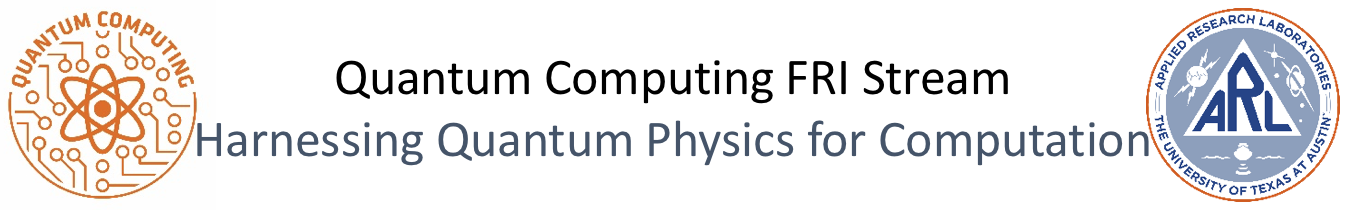

# Shor's Algorithm
## Lesson 13

### Installations and Imports

In [1]:
#In case you don't have qiskit, install it now
%pip install qiskit --quiet
%pip install qiskit-aer --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 50.3 MB/s eta 0:00:00


In [2]:
#Installing/upgrading pylatexenc seems to have fixed my mpl issue
#If you try this and it doesn't work, try also restarting the runtime/kernel
%pip install pylatexenc --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
#Let's go ahead and import all this stuff too
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
import numpy as np
from qiskit.visualization import plot_histogram

In [4]:
from qiskit.circuit.library import QFT

def built_in_qft(qc, qubits, n):

    gate=QFT(num_qubits=n, approximation_degree=0, do_swaps=True, inverse=False, insert_barriers=False, name='qft')
    qc.append(gate, qubits)

    return qc

def built_in_iqft(qc, qubits, n):

    gate=QFT(num_qubits=n, approximation_degree=0, do_swaps=True, inverse=True, insert_barriers=False, name='iqft')
    qc.append(gate, qubits)

    return qc

In [5]:
#recursive CCC..CC Z^a
#control registers Cr must be an array or list
#target register is Tr
def recCZa(qc,a,Cr,Tr):
    if len(Cr)<=1:
        if len(Cr)==1:          #if only 1 control bit, apply the C-gate
            qc.cp(np.pi*a,Cr[0],Tr)
        else:                   #if no control bits, just apply the gate
            qc.p(np.pi*a,Tr)
    else:
        nn=len(Cr)
        #apply C-sqrt(U)
        recCZa(qc,a/2,[Cr[nn-1]],Tr)

        #recursively apply CCNot
        qc.h(Cr[nn-1])
        recCZa(qc,1,Cr[0:nn-1],Cr[nn-1])
        qc.h(Cr[nn-1])

        #apply C-sqrt(U dg)
        recCZa(qc,-a/2,[Cr[nn-1]],Tr)

        #recursively apply CCNot
        qc.h(Cr[nn-1])
        recCZa(qc,1,Cr[0:nn-1],Cr[nn-1])
        qc.h(Cr[nn-1])

        #recursivle apply CC-sqrt(U)
        recCZa(qc,a/2,Cr[0:nn-1],Tr)

def recTof(qc,Cr,Tr):
#Toffoli gate using recursive CZa
    qc.h(Tr)
    recCZa(qc,1,Cr,Tr)
    qc.h(Tr)

## Today's Objectives

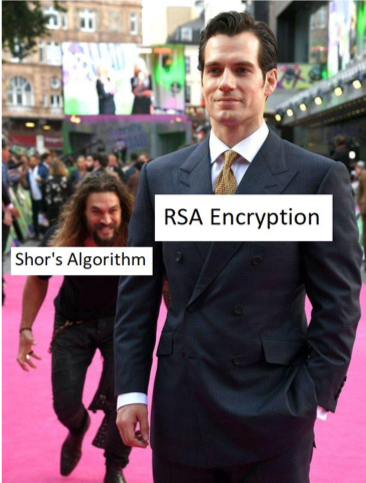

 - Remember/continue learning Order Finding
 - Interpret the results from the order finding algorithm
 - Factor a given number using the order finding algorithm (Shor's factoring algorithm)

## Order Finding Reminder

$\text{Let }b\text{ and }M\text{ be positive integers such that}$
 - $1\lt b \lt M$
 - $b\text{ and }M\text{ are co-prime (share no common factors)}$

$\text{The }\textbf{order}\text{ of }b \text{ mod } M \text{ is the smallest positive integer }r \text{ such that}$

$$b^{r}\text{mod }M\equiv 1$$


$$\text{Classical order finding requires }\mathcal{O}(2^{m}) \text{ operations}$$

To implement a quantum algorithm, we need a quantum circuit that realizes

$$\mathbf{V}_{b,M}\lvert x\rangle\lvert 1\rangle = \lvert x\rangle\lvert b^{x}\text{mod }M\rangle \qquad \text{ for }x\lt N=2^{n}$$

## Quantum Order Finding Algorithm

$1. \text{ Begin with the state }\lvert{0}\rangle\lvert{1}\rangle \text{ with }n \text{ input qubits and }m \text{ output qubits.}$
$\quad\left(\text{The output should be in state }\lvert{0\dots 01}\rangle\right)$

$ $

$2. \text{ Apply Hadamards to the input register to create a superposition.}$

$$\lvert{0}\rangle\lvert{1}\rangle \longrightarrow \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \lvert x\rangle\lvert 1\rangle$$

$ $

$3. \text{ Apply }\mathbf{V}_{b,M} \text{ to the superposition.}$

$$\mathbf{V}_{b,M}\frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \lvert x\rangle\lvert 1\rangle= \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \lvert x\rangle\lvert b^{x}\text{mod }M\rangle$$

$ $

$4. \text{ Apply IQFT to the input register. If }r=2^{p}\leq N, \text{ then }$

$$\begin{align}
\frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \lvert x\rangle\lvert b^{x}\text{mod }M\rangle\overset{IQFT}{\longrightarrow} &\frac{1}{\sqrt{r}} \sum_{s=0}^{r-1} \lvert s 2^{n-p}\rangle\lvert u_{s}\rangle \\
=& \frac{1}{\sqrt{r}} \left[ \lvert 0\rangle\lvert u_{0}\rangle + \lvert 1* 2^{n-p}\rangle\lvert u_{1}\rangle + \cdots + \lvert (r-1)*2^{n-p}\rangle\lvert u_{r-1}\rangle \right]
\end{align}$$

$ $

$5. \text{ Measure the input register to obtain }x \in \{0,\dots,2^{n}-1\}$

$ $

$6. \text{ Find }s \text{ and } r \text{ such that }s/r \approx x/2^{n} \text{ (This may be tricky)}$

### Interpreting Your Measurements

$\text{According to step 4 of the algorithm, for }r=2^{p} \text{ and } s\in \{0,1,\dots,r-1\}, \text{ any one measurement result }x \text{ should be such that }$

$$ x = s*2^{n-p} $$

$ \text{ We can convert this into a fraction by considering the entire } N=2^{n} \text{ space.}$

$$\begin{align}
\frac{x}{2^{n}} =& \frac{s*2^{n-p}}{2^{n}}
= s*2^{-p} \\
=& \frac{s}{2^{p}}
= \frac{s}{r}
\end{align}$$

$$\Rightarrow \boxed{\frac{s}{r}\in\bigg\lbrace 0,\frac{1}{2^{p}},\frac{2}{2^{p}},\dots,\frac{r-1}{2^{p}}\bigg\rbrace }$$

$\text{ Do this for each measurement result to obtain } \frac{s_{1}}{r_{1}},\frac{s_{2}}{r_{2}},\dots$

$ \text{ We then find the least common denominator for our series of fractions in order to extract }r.$



#### <font color=green> Exercise </font>

The following results histogram was output by a job with only 32 shots. (All aspects of the state may not be fully represented.)

1) Identify the bit-strings of interest.

2) Convert them into fractions.

3) Find the least common denominator, and use that to identify the order.

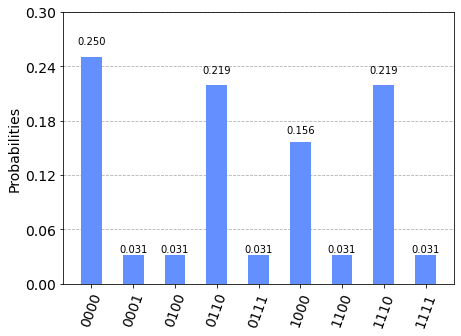

The bitstrings of interest are 0110, 1000, and 1110

As fractions, these are 6/16, 8/16, and 14/16

The least common denominator is 8, so the order is 8

### What to do if $r$ is not a power of 2?

If we want to get really mathy, we could use a continued fraction expansion, but there's a different trick we can use with this sort of output.

What we really get as output is a series of bit-strings that we interpret as fractions: $\frac{x_{1}}{2^{n}} ,\frac{x_{2}}{2^{n}} ,…$

We want to convert this to another series of fractions: $\frac{s_{1}}{r},\frac{s_{2}}{r},…$

$\text{We can use the relative signals of each }x_{i}\text{ to find weighted averages
and approximate the fractions }\frac{s_{i}}{r}$

### Output Interpretation Example

Execute the following cells to run Order Finding with the “oracle” V4mod21 with n=2, m=5

In [6]:
def V4mod21(qc, qx, qy):
    # qc is a quantum circuit with quantum registers qx and qy
    # qx has at least 2 qubit; qy has at least 5 qubits
    # transforms |x, 1> to |x,y> = |x, 4**x % 21>

    qc.x(qy[0])
    # x = 00 implies y = 00001
    qc.x(qx[0])
    qc.x(qx[1])
    qc.ccx(qx[0], qx[1], qy[0])
    qc.x(qx[1])
    qc.x(qx[0])
    # x = 01 implies y = 00100
    qc.x(qx[1])
    qc.ccx(qx[0], qx[1], qy[2])
    qc.x(qx[1])
    # x = 10 implies y = 10000
    qc.x(qx[0])
    qc.ccx(qx[0], qx[1], qy[4])
    qc.x(qx[0])
    # x = 11 implies y = 00001
    qc.ccx(qx[0], qx[1], qy[0])

{'00': 388, '10': 139, '11': 257, '01': 240}


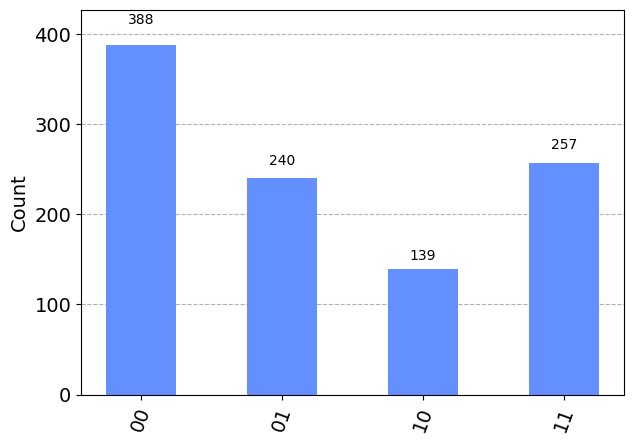

In [8]:
# set up quantum registers qx, qy and classical registers cx
n = 2
m = 5
qx = QuantumRegister(n)
qy = QuantumRegister(m)
cx = ClassicalRegister(len(qx))
qc = QuantumCircuit(qy, qx, cx)

# order-finding algorithm
qc.x(qy[0])
for i in range(len(qx)):
    qc.h(qx[i])
# V7mod15(qc, qx, qy)
# V11mod15(qc, qx, qy)
V4mod21(qc, qx, qy)
built_in_iqft(qc, qx, n)

# measure the input register
for i in range(len(qx)):
    qc.measure(qx[i], cx[i])

# execute the quantum circuit
backend=Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1024)
data = job.result().get_counts()
print(data)
plot_histogram(data)

These measurement signals are not as prominent as before, because the true values lie between the measured outcomes.

n=2 tells us the size of the space is 2^2=4.

Let us convert our binary outputs into fractions.

$$01 \rightarrow 1 \Rightarrow 1/4=.25 \qquad 10 \rightarrow 2 \Rightarrow 2/4=.5	\qquad 11 \rightarrow 3 \Rightarrow 3/4=.75$$


We can associate the counts with variables by accessing the dictionary.

In [9]:
count25=data['01']
print(count25)
count50=data['10']
print(count50)
count75=data['11']
print(count75)

240
139
257


The true values are likely nearer to the higher peaks than the lower peaks.

We can use the number of counts for neighboring outputs to weight the averages of their values.

In [10]:
weightedAvg1=(0.25*count25+.5*count50)/(count25+count50)
print(weightedAvg1)

0.341688654353562


In [11]:
weightedAvg2=(0.5*count50+.75*count75)/(count50+count75)
print(weightedAvg2)

0.6622474747474747


We can see that these values are approximately $\frac{1}{3}, \frac{2}{3}$

By combining the peaks we measured, we were able to identify the pattern!


#### Adding more qubits

We can do the same on a larger number of qubits to see how are results are affected.

In [12]:
def VbmodM(b,M,qc,qx,qy):#Cheaty implementation of a general isometry which calculates b^x modM
#This function consists of 2 parts:
#The classical part generates the results of b^x modM and the minimum number of input qubits needed
#The quantum part uses the classical results to apply the appropriate controlled gates

#Clasical Part
    #first run the classical algorithm to determine the answers and how many bits to make the inputs
    temporder=0
    classans=[1]
    for x in range(1,M):
        classans.append(pow(b, x, M))
        if (classans[x]==1):
            temporder=x
        if temporder>0:
            if x%2==0:
                break

    #find the minimum necessary number of qubits
    nq=1
    tx=x
    for i in range(x):
        tx/=2
        if tx>=1:
            nq+=1
        else:
            break
    mq=1
    tx=max(classans)
    for i in range(max(classans)):
        tx/=2
        if tx>=1:
            mq+=1
        else:
            break

    if len(qx)!=nq:
        print("Use ",nq, "qubits for qx")
        if len(qy)!=mq:
            print("Use ",mq, "qubits for qy")
        return False
    if len(qy)!=mq:
        print("Use ",mq, "qubits for qy")
        if len(qx)!=nq:
            print("Use ",nq, "qubits for qx")
        return False


    xs=[bin(i)[2:].zfill(nq) for i in range(2**nq)]
    ys=[bin(pow(b,i,M))[2:].zfill(mq) for i in range(2**nq)]


#Quantum Part
    #NOT the first output qubit
    qc.x(qy[0])

    #specify control bits #in this case they are just the qx bits
    controls=[]
    for i in range(len(qx)):
        controls.append(qx[i])

    #apply the controlled gates to do the math
    for i in range(2**nq):

        #isolate the digits in each x
        #if that digit is 0 then flip the corresponding control bit
        for j in range(len(xs[i])):
            if xs[i][j]=='0':
                qc.x(controls[(len(xs[i])-1)-j])

        #isolate the digits in the corresponding y
        #apply the toffoli to each of the corresponding target bits
        for j in range(len(qy)):
            if ys[i][j]=='1':
                recTof(qc,controls,qy[(len(ys[i])-1)-j])

        #uncompute the control qubits
        for j in range(len(xs[i])):
            if xs[i][j]=='0':
                qc.x(controls[(len(xs[i])-1)-j])

{'001': 12, '100': 47, '111': 11, '011': 251, '110': 75, '101': 235, '010': 56, '000': 337}


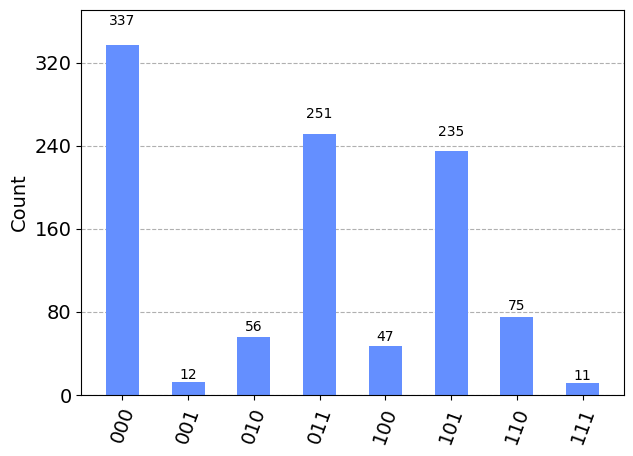

In [13]:
# set up quantum registers qx, qy and classical registers cx
n = 3
m = 5
qx = QuantumRegister(n)
qy = QuantumRegister(m)
cx = ClassicalRegister(len(qx))
qc = QuantumCircuit(qy, qx, cx)

# order-finding algorithm
qc.x(qy[0])
for i in range(len(qx)):
    qc.h(qx[i])

VbmodM(4,21,qc,qx,qy)
built_in_iqft(qc, qx, n)

# measure the input register
for i in range(len(qx)):
    qc.measure(qx[i], cx[i])

# execute the quantum circuit
backend=Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1024)
data = job.result().get_counts(qc)
print(data)
plot_histogram(data)

In [14]:
count25=data['010']
print(count25)
count375=data['011']
print(count375)
count625=data['101']
print(count625)
count75=data['110']
print(count75)

56
251
235
75


In [15]:
weightedAvg1=(0.25*count25+.375*count375)/(count25+count375)
print(weightedAvg1)

0.3521986970684039


In [16]:
weightedAvg2=(0.625*count625+.75*count75)/(count625+count75)
print(weightedAvg2)

0.655241935483871


Increasing the size gains the benefit of each fraction being closer to the actual value, but it spreads the probabilities more across the incorrect answers!

## Finding Factors

$\text{Given a positive integer }N, \text{ how do we factor it?}$

$\text{Easy stuff:}$
- If $N$ is even, then 2 is obviously a factor.
- If $N$ is prime, there's nothing to be done! (1 is not considered prime)

One could now just try all the primes less than $N$, but perhaps there is a better way...

### Selecting parameters for order finding

$\text{Suppose we pick a number }b\in \{1,\dots,N-1\} \text{ at random.}$

$\text{If }\texttt{gcd}(b,N)>1,\text{ then }c=\texttt{gcd}(b,N) \text{ is a common factor of }b \text{ and }N.$

$\quad\color{blue}{c \text{ is a nontrivial factor of }N, \text{ and we're done!}}$

$\text{If }\texttt{gcd}(b,N)=1,\text{ then we can find the order }r\text{ of }b \text{ mod }N.$

- Use the classical algorithm to find $r$
- Use the quantum algorithm to find $r$



### From Order Finding to Factoring - Shor's Factoring Algorithm

$\text{Suppose }r \text{ is the order of }b\text{ mod }N: \quad b^{r}\equiv1\text{ mod }N$

$\text{Let }x=b^{r/2}\text{ mod }N \qquad \left(\text{If }r\text{ is odd this is no good; }\color{red}{\text{ Pick a new b and try again!}}\right)$

$\quad\text{Note that }x^{2}-1=\left(x-1\right)\left(x+1\right)= 0\text{ mod }N$

$\quad\color{blue}{\text{ because }x^{2}-1=b^{r}-1\equiv 0\text{ mod }N}$


$\boxed{\textbf{Theorem: }\text{If }x-1\neq 0\text{ mod }N \text{ and }x+1\neq 0\text{ mod }N, \text{ then at least one of }\texttt{gcd}\left(x-1,N\right) \text{ or } \texttt{ gcd}\left(x+1,N\right) \text{ is a nontrivial factor of }N.\;}$

### Checking Theorem Conditions

$\text{We want to know if }x-1\neq 0\text{ mod }N \text{ and }x+1\neq 0\text{ mod }N $

$\text{Note that it's }always \text{ true that }x-1\neq 0\text{ mod }N $
$\quad\color{blue}{\text{ If it were, then we'd have }b^{r/2}\equiv 1\text{ mod }N, \text{ but }r \text{ is the smalest such value!}}$

$\text{Is }x+1\neq 0\text{ mod }N? \text{ Maybe, maybe not.} $
$\quad\color{blue}{\text{ We need to check. If so, then we're good to go!}}$



### <font color=green> Exercise </font>

$\text{Let's implement Shor's factoring algorithm by revisiting an old order finding example.}$

$\text{Find the prime factors of }N=15 \text{ with a }``\text{randomly" chosen }b=7$

1) Find $\texttt{gcd(b,N)}$

In [17]:
np.gcd(7, 15)

1

2) Find the order such that $b^{r}=1\text{ mod }N$

*Hint: You have solved this multiple times already.*

In [18]:
r=1
b=7
N=15
while (b**r) % N != 1:
    r += 1
print(r)

4


3) Find $x=b^{r/2}\text{ mod }N$

In [24]:
x =b**(r//2)%N
print(x)

4


4) Check that $x-1\neq 0\text{ mod }N$ and $x+1\neq 0\text{ mod }N$

If this is true, find $\texttt{gcd}\left(x-1,N\right)$ or $\texttt{ gcd}\left(x+1,N\right)$ in order to factor $N$.

In [26]:
print((x-1)%N)
print((x+1)%N)

print(np.gcd((x-1),N))
print(np.gcd((x+1),N))
print("N's factors are 3 and 5")

3
5
3
5
N's factors are 3 and 5
